## Introducción a las series de tiempo

A modo de introducción, se usará datos peruanos mensuales y trimestrales para mostrar las principales manipulaciones y estadísticas que se pueden extraer de una serie de tiempo. Los datos se extraerán de la API del BCRP mediante una función creada llamada `get_data` en la carpeta `utils.py`

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.seasonal import STL

import warnings
warnings.simplefilter("ignore")

%run "../utils.py"

Los datos mensuales:
* PN01207PM: Tipo de Cambio Interbancario - Promedio
* PD04722MM: Tasa de Referencia de la Política Monetaria
* PN38705PM: Índice de Precios al Consumidor (IPC)

Los datos trimestrales:
* PN02538AQ: PBI

In [2]:
df_mens = get_data(
    {
        "PN01207PM": "Tipo de Cambio Interbancario - Promedio",
        "PD04722MM": "Tasa de Referencia de la Política Monetaria",
        "PN38705PM": "Índice de Precios al Consumidor (IPC)"
    },
    fechaini = "1995-01",
    fechafin = "2019-12"
)

df_trim = get_data(
    {
        "PN02538AQ": "PBI (millones S/2007)"
    },
    fechaini = "1993Q1",
    fechafin = "2019Q4"
)

df_mens.tail()

,Tipo de Cambio Interbancario - Promedio,Tasa de Referencia de la Política Monetaria,Índice de Precios al Consumidor (IPC)
time,,,
2019-08-01,3.378710,2.50,91.735293
2019-09-01,3.357190,2.50,91.741149
2019-10-01,3.360076,2.50,91.842730
2019-11-01,3.372715,2.25,91.942756
2019-12-01,3.354738,2.25,92.139993


### Transformaciones
### 1) Índice
Para reducir las dimensiones de una serie se puede fijar los valores a un periodo base=100: $$y_t = \frac{x_t}{x_b}*100$$

In [3]:
# Índice de IPC como el promedio del año 2009
ipc = df_mens["Índice de Precios al Consumidor (IPC)"]
df_mens["IPC (2009=100)"] = ( ipc / ipc[ipc.index.get_level_values(0) == "2009"].mean() ) *100

df_mens.tail()

,Tipo de Cambio Interbancario - Promedio,Tasa de Referencia de la Política Monetaria,Índice de Precios al Consumidor (IPC),IPC (2009=100)
time,,,,
2019-08-01,3.378710,2.50,91.735293,132.162008
2019-09-01,3.357190,2.50,91.741149,132.170444
2019-10-01,3.360076,2.50,91.842730,132.316790
2019-11-01,3.372715,2.25,91.942756,132.460897
2019-12-01,3.354738,2.25,92.139993,132.745053


### 2) Trimestralización
Se puede resamplear los datos mensuales basado en los valores promedios (pdp: promedio de periodo) o mantiendo los valores finales (fdp: fin de periodo). Por lo general, la trimestralización mediante pdp es el más usado

In [4]:
# Promedio de periodo
df_pdp = df_mens.resample("Q").mean()
df_pdp.index = df_pdp.index.date

df_pdp.tail()

,Tipo de Cambio Interbancario - Promedio,Tasa de Referencia de la Política Monetaria,Índice de Precios al Consumidor (IPC),IPC (2009=100)
2018-12-31,3.358267,2.750000,90.275723,130.059221
2019-03-31,3.323244,2.750000,90.777142,130.781610
2019-06-30,3.320795,2.750000,91.501026,131.824502
2019-09-30,3.342102,2.583333,91.718611,132.137973
2019-12-31,3.362510,2.333333,91.975159,132.507580


In [5]:
# Fin de periodo
df_fdp = df_mens.resample("Q").last()
df_fdp.index = df_fdp.index.date

df_fdp.tail()

,Tipo de Cambio Interbancario - Promedio,Tasa de Referencia de la Política Monetaria,Índice de Precios al Consumidor (IPC),IPC (2009=100)
2018-12-31,3.364384,2.75,90.421894,130.269808
2019-03-31,3.304319,2.75,91.254794,131.469758
2019-06-30,3.325475,2.75,91.493350,131.813443
2019-09-30,3.357190,2.50,91.741149,132.170444
2019-12-31,3.354738,2.25,92.139993,132.745053


In [6]:
# Transformación del formato de una fecha trimestral
df_trim_antiguo = df_trim.copy()

df_trim.index = pd.period_range("1994Q1", "2019Q4", freq="Q")
df_trim.index = df_trim.index.to_timestamp(how="end").date

print("Formato anterior:")
print(df_trim_antiguo.tail())
print("\n")
print("Formato nuevo:")
print(df_trim.tail())

Formato anterior:
       PBI (millones S/2007)
time                        
Q4.18             140987.792
Q1.19             127552.580
Q2.19             137222.599
Q3.19             138013.199
Q4.19             143816.622


Formato nuevo:
            PBI (millones S/2007)
2018-12-31             140987.792
2019-03-31             127552.580
2019-06-30             137222.599
2019-09-30             138013.199
2019-12-31             143816.622


#### 3) Logaritmos
La corrección matemática por logaritmos reduce el efecto de valores cada ver mayores: $$y_t = log(x_t)$$

In [7]:
df_trim["Logaritmo del PBI"] = np.log(df_trim)

df_trim.tail()

,PBI (millones S/2007),Logaritmo del PBI
2018-12-31,140987.792,11.856429
2019-03-31,127552.580,11.756284
2019-06-30,137222.599,11.829360
2019-09-30,138013.199,11.835105
2019-12-31,143816.622,11.876294


#### 4) Variaciones

Por lo general, la transformación de una serie de niveles a variaciones es para que estas nuevas series se conviertan en estacionarias. Se puede realizar hallar la variación con respecto a "i" periodos mediante dos maneras:
* División: $$y_t = \dfrac{x_t}{x_{t-i}}-1$$

* Logaritmos: $$y_t = log(x_t) - log(x_{t-1})$$

No obstante, la variacion por logaritmos es una aproximación que es muy exacta si la serie es de una dimensión pequeña 

In [8]:
# 1: variaciones interanuales
pbi = df_trim["PBI (millones S/2007)"]
df_trim["PBI (var. % anual) 1"] = ( pbi/pbi.shift(4) -1) *100

df_trim.tail()

,PBI (millones S/2007),Logaritmo del PBI,PBI (var. % anual) 1
2018-12-31,140987.792,11.856429,4.651280
2019-03-31,127552.580,11.756284,2.436272
2019-06-30,137222.599,11.829360,1.169576
2019-09-30,138013.199,11.835105,3.363626
2019-12-31,143816.622,11.876294,2.006436


In [9]:
# 2: diferencias a logaritmos
lnpbi = df_trim["Logaritmo del PBI"]
df_trim["PBI (var. % anual) 2"] = ( lnpbi - lnpbi.shift(4) ) *100

df_trim.tail()

,PBI (millones S/2007),Logaritmo del PBI,PBI (var. % anual) 1,PBI (var. % anual) 2
2018-12-31,140987.792,11.856429,4.651280,4.546349
2019-03-31,127552.580,11.756284,2.436272,2.407068
2019-06-30,137222.599,11.829360,1.169576,1.162789
2019-09-30,138013.199,11.835105,3.363626,3.308293
2019-12-31,143816.622,11.876294,2.006436,1.986572


#### 5) Ajuste cícilco
Varias series se pueden descomponer por un tendencia ($T_t$), ciclo ($C_t$) y residuo ($R_t$). La descomposición puede ser de dos maneras: 
* Aditiva:  $y_t = T_t + C_t + R_t$
* Multiplicativa:  $y_t = T_t * C_t * R_t$

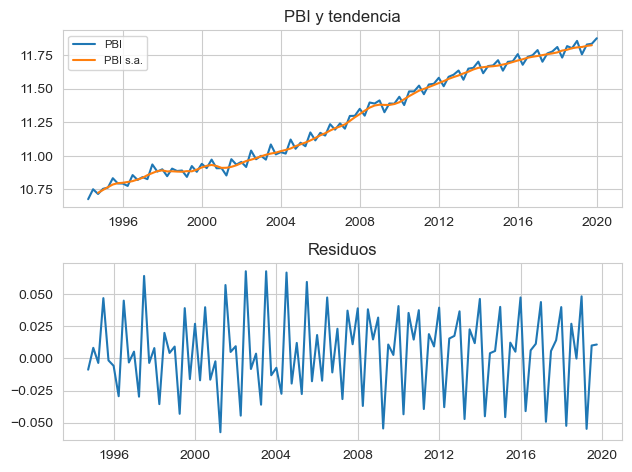

In [10]:
# Moving average
df_trim["PBI.sa (media móvil)"] = df_trim["Logaritmo del PBI"].rolling(window=4, center=True).mean()
resid = df_trim["Logaritmo del PBI"] - df_trim["PBI.sa (media móvil)"]


fig, ax = plt.subplots(2, 1)

ax[0].plot(df_trim["Logaritmo del PBI"], label="PBI")
ax[0].plot(df_trim["PBI.sa (media móvil)"], label="PBI s.a.")
ax[1].plot(resid)

ax[0].legend(fontsize=8)
ax[0].set_title("PBI y tendencia")
ax[1].set_title("Residuos")

fig.tight_layout(pad=1)
plt.show()

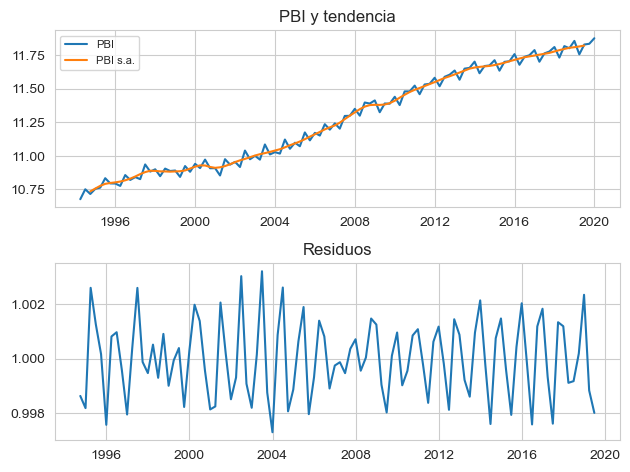

In [11]:
# tsa.seasonal_decompose
sd = tsa.seasonal_decompose(df_trim["Logaritmo del PBI"], model="multiplicative", period=4)


fig, ax = plt.subplots(2, 1)

ax[0].plot(df_trim["Logaritmo del PBI"], label="PBI")
ax[0].plot(sd.trend, label="PBI s.a.")
ax[1].plot(sd.resid)

ax[0].legend(fontsize=8)
ax[0].set_title("PBI y tendencia")
ax[1].set_title("Residuos")

fig.tight_layout(pad=1)
plt.show()

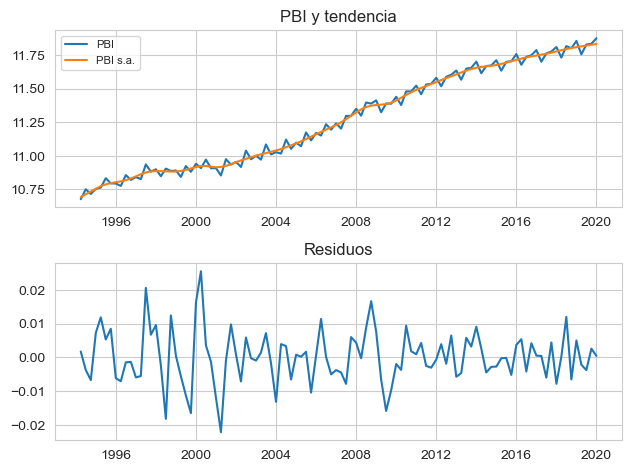

In [12]:
# tsa.seasonal.STL
stl = STL(df_trim["Logaritmo del PBI"], period=4, seasonal=9, trend_deg=1).fit()


fig, ax = plt.subplots(2, 1)

ax[0].plot(df_trim["Logaritmo del PBI"], label="PBI")
ax[0].plot(stl.trend, label="PBI s.a.")
ax[1].plot(stl.resid)

ax[0].legend(fontsize=8)
ax[0].set_title("PBI y tendencia")
ax[1].set_title("Residuos")

fig.tight_layout(pad=1)
plt.show()

### Estadísticas

In [13]:
# Modificaciones previas
df_pdp["Inflación"] = (df_pdp["Índice de Precios al Consumidor (IPC)"]/df_pdp["Índice de Precios al Consumidor (IPC)"].shift(4) - 1) *100
df = pd.concat([df_pdp, df_trim], axis=1)
df = df[["Tipo de Cambio Interbancario - Promedio", "PBI (var. % anual) 1",
         "Inflación", "Tasa de Referencia de la Política Monetaria"]].dropna()
df.rename({"PBI (var. % anual) 1": "PBI (var. % anual)"}, axis=1, inplace=True)

df.tail()

,Tipo de Cambio Interbancario - Promedio,PBI (var. % anual),Inflación,Tasa de Referencia de la Política Monetaria
2018-12-31,3.358267,4.651280,2.066755,2.750000
2019-03-31,3.323244,2.436272,2.126855,2.750000
2019-06-30,3.320795,1.169576,2.537244,2.750000
2019-09-30,3.342102,3.363626,2.000737,2.583333
2019-12-31,3.362510,2.006436,1.882495,2.333333


In [14]:
# Dimensiones
T, k = df.shape

print(f"Observaciones: {T}\nVariables: {k}")

Observaciones: 66
Variables: 4


In [15]:
# Tipos de datos
df.dtypes

Tipo de Cambio Interbancario - Promedio        float64
PBI (var. % anual)                             float64
Inflación                                      float64
Tasa de Referencia de la Política Monetaria    float64
dtype: object

In [16]:
# Principales estadísticas
df.describe()

,Tipo de Cambio Interbancario - Promedio,PBI (var. % anual),Inflación,Tasa de Referencia de la Política Monetaria
count,66.000000,66.000000,66.000000,66.000000
mean,3.090250,5.103369,2.835653,3.656566
std,0.269349,2.725916,1.332845,1.100458
min,2.574898,-0.733584,0.414459,1.250000
25%,2.816595,2.869239,1.923502,2.791667
50%,3.188592,5.102367,2.934232,3.708333
75%,3.313950,6.480080,3.506351,4.250000
max,3.478114,11.424358,6.645813,6.500000


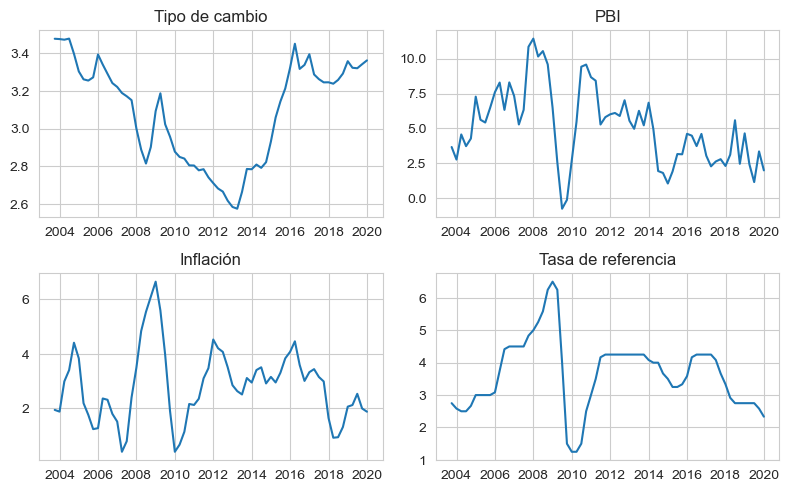

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(8,5))

ax[0,0].plot(df["Tipo de Cambio Interbancario - Promedio"], label="Tipo de cambio")
ax[0,0].set_title("Tipo de cambio")

ax[0,1].plot(df["PBI (var. % anual)"], label="PBI")
ax[0,1].set_title("PBI")

ax[1,0].plot(df["Inflación"], label="Inflación")
ax[1,0].set_title("Inflación")

ax[1,1].plot(df["Tasa de Referencia de la Política Monetaria"], label="Tasa de referencia")
ax[1,1].set_title("Tasa de referencia")

fig.tight_layout(pad=1)
plt.show()